Moral of this notebook:
Before I was checking the ClKK between camb and ours. I thought I had turned off the non-linear matter power spectrum part of the computation for ClKK but I had forgotten to set `lens_potential_accuracy=0` so in the computation of ClKK from camb, nonlinear matter was still being used. When the linear matter spectrum is used, everything matches

In [1]:
import numpy as np

In [2]:
from LIMxCMBL.init import *

In [3]:
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()




In [4]:
from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD)

[]

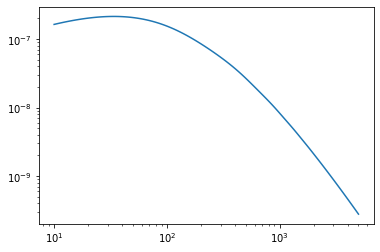

In [5]:
plt.plot(ells, ClKK)
plt.loglog()

[]

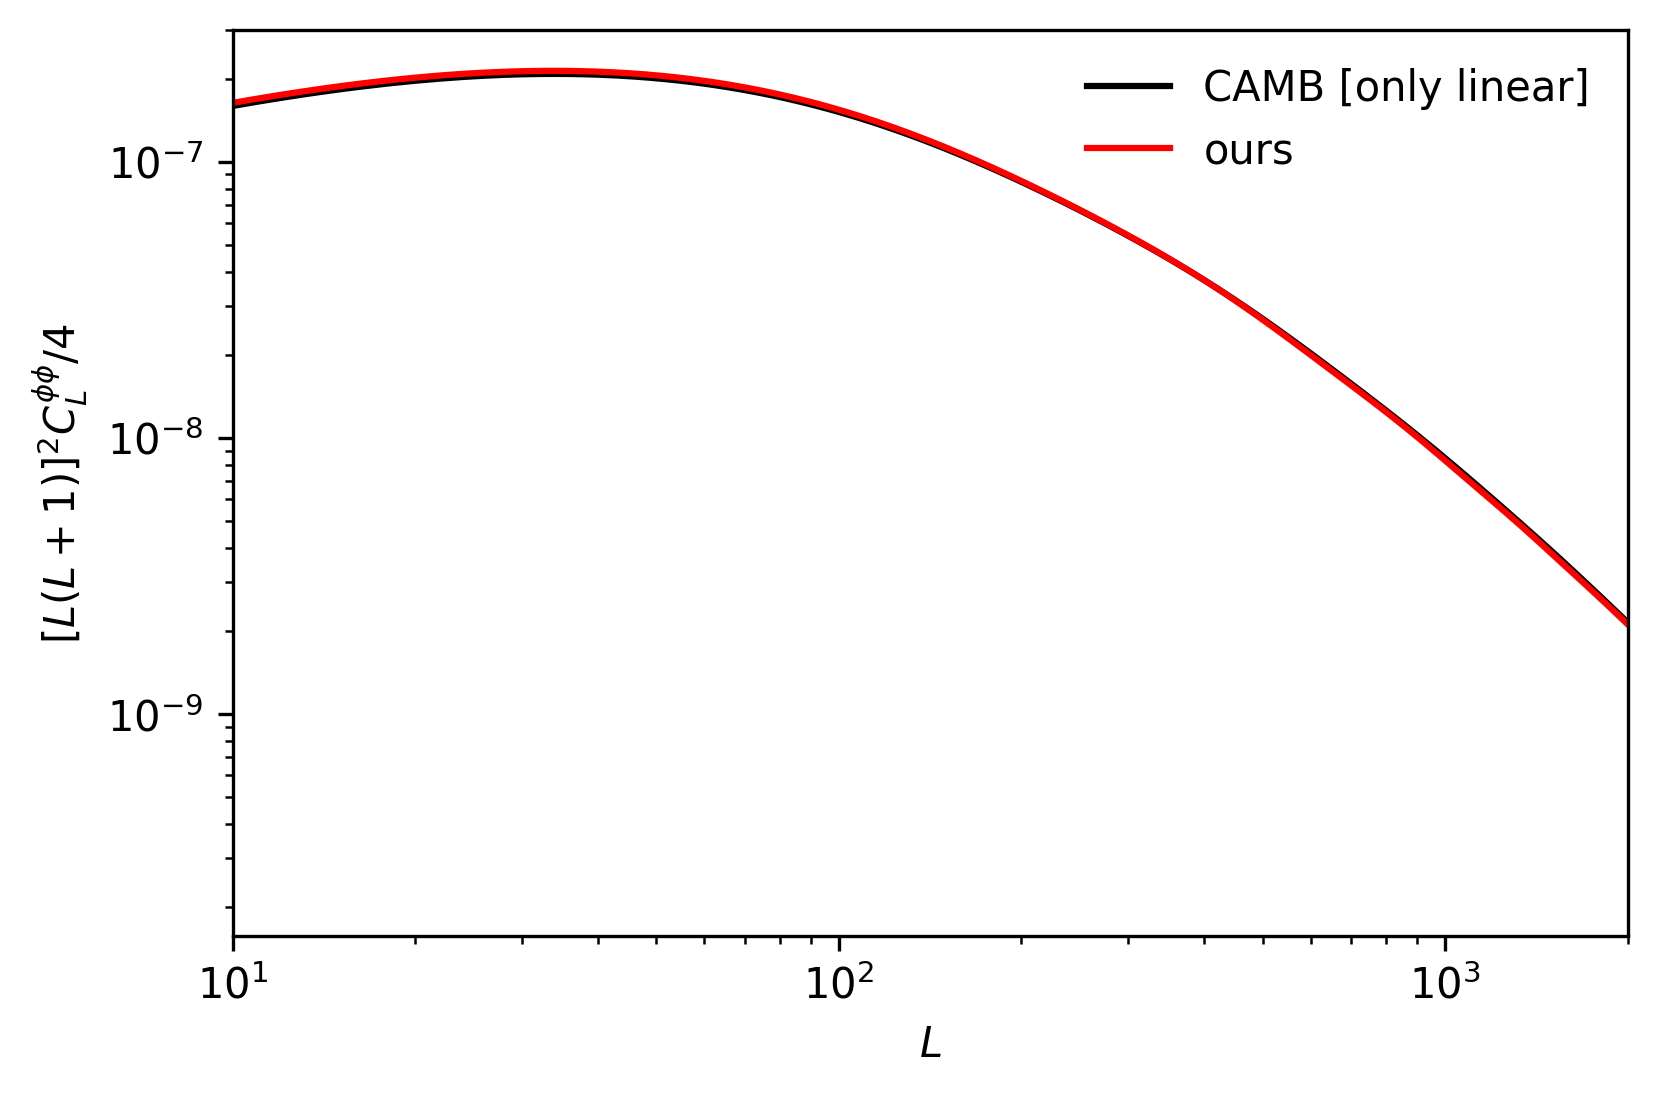

In [6]:
import camb
from camb import model, initialpower

H0 = 100 * h
plt.figure(dpi=300, facecolor='w')
pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
pars.InitPower.set_params(ns=ns)
pars.NonLinear = model.NonLinear_none
pars.set_for_lmax(int(max(ells)), lens_potential_accuracy=0)
#problem was that I was setting pars.NonLinear to none 
#but then lens_potential_accuracy !=0 restored nonlinear matter
#for computation of lensing

results = camb.get_results(pars)
cl = results.get_lens_potential_cls(lmax=int(max(ells)))


plt.plot(np.arange(int(max(ells)) + 1)[10:], cl[10:,0] * 2*np.pi / 4, 'k', label='CAMB [only linear]')
plt.plot(ells, ClKK, 'r', label='ours')

plt.legend(frameon = False)
plt.ylabel('$[L(L+1)]^2C_L^{\phi\phi}/4$')
plt.xlabel('$L$')
plt.xlim([10,2000]);

plt.loglog()

In [7]:
nz = 100
kmax=10  #kmax to use
results= camb.get_background(pars)
chistar = results.conformal_time(0)- results.tau_maxvis
chis = np.linspace(0,chistar,nz)
zs=results.redshift_at_comoving_radial_distance(chis)
#Calculate array of delta_chi, and drop first and last points where things go singular
dchis = (chis[2:]-chis[:-2])/2
chis = chis[1:-1]
zs = zs[1:-1]

In [8]:
PK = camb.get_matter_power_interpolator(pars, nonlinear=False, 
    hubble_units=False, k_hunit=False, kmax=kmax,
    var1=model.Transfer_Weyl,var2=model.Transfer_Weyl, zmax=zs[-1])

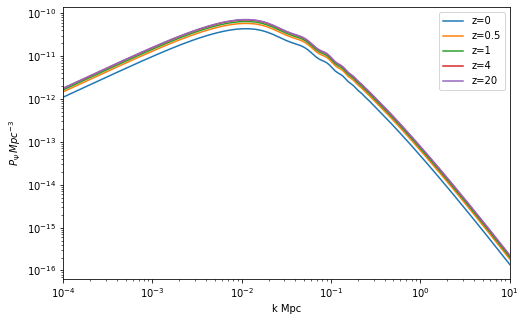

In [9]:
#Have a look at interpolated power spectrum results for a range of redshifts
#Expect linear potentials to decay a bit when Lambda becomes important, and change from non-linear growth
plt.figure(figsize=(8,5))
k=np.exp(np.log(10)*np.linspace(-4,2,200))
zplot = [0, 0.5, 1, 4 ,20]
for z in zplot:
    plt.loglog(k, PK.P(z,k))
plt.xlim([1e-4,kmax])
plt.xlabel(r'k Mpc')
plt.ylabel('$P_\Psi\, Mpc^{-3}$')
plt.legend(['z=%s'%z for z in zplot]);

In [10]:
#Get lensing window function (flat universe)
win = ((chistar-chis)/(chis**2*chistar))**2
#Do integral over chi
ls = np.arange(2,2500+1, dtype=np.float64)
cl_kappa=np.zeros(ls.shape)
w = np.ones(chis.shape) #this is just used to set to zero k values out of range of interpolation
for i, l in enumerate(ls):
    k=(l+0.5)/chis
    w[:]=1
    w[k<1e-4]=0
    w[k>=kmax]=0
    cl_kappa[i] = np.dot(dchis, w*PK.P(zs, k, grid=False)*win/k**4)
cl_kappa*= (ls*(ls+1))**2

[]

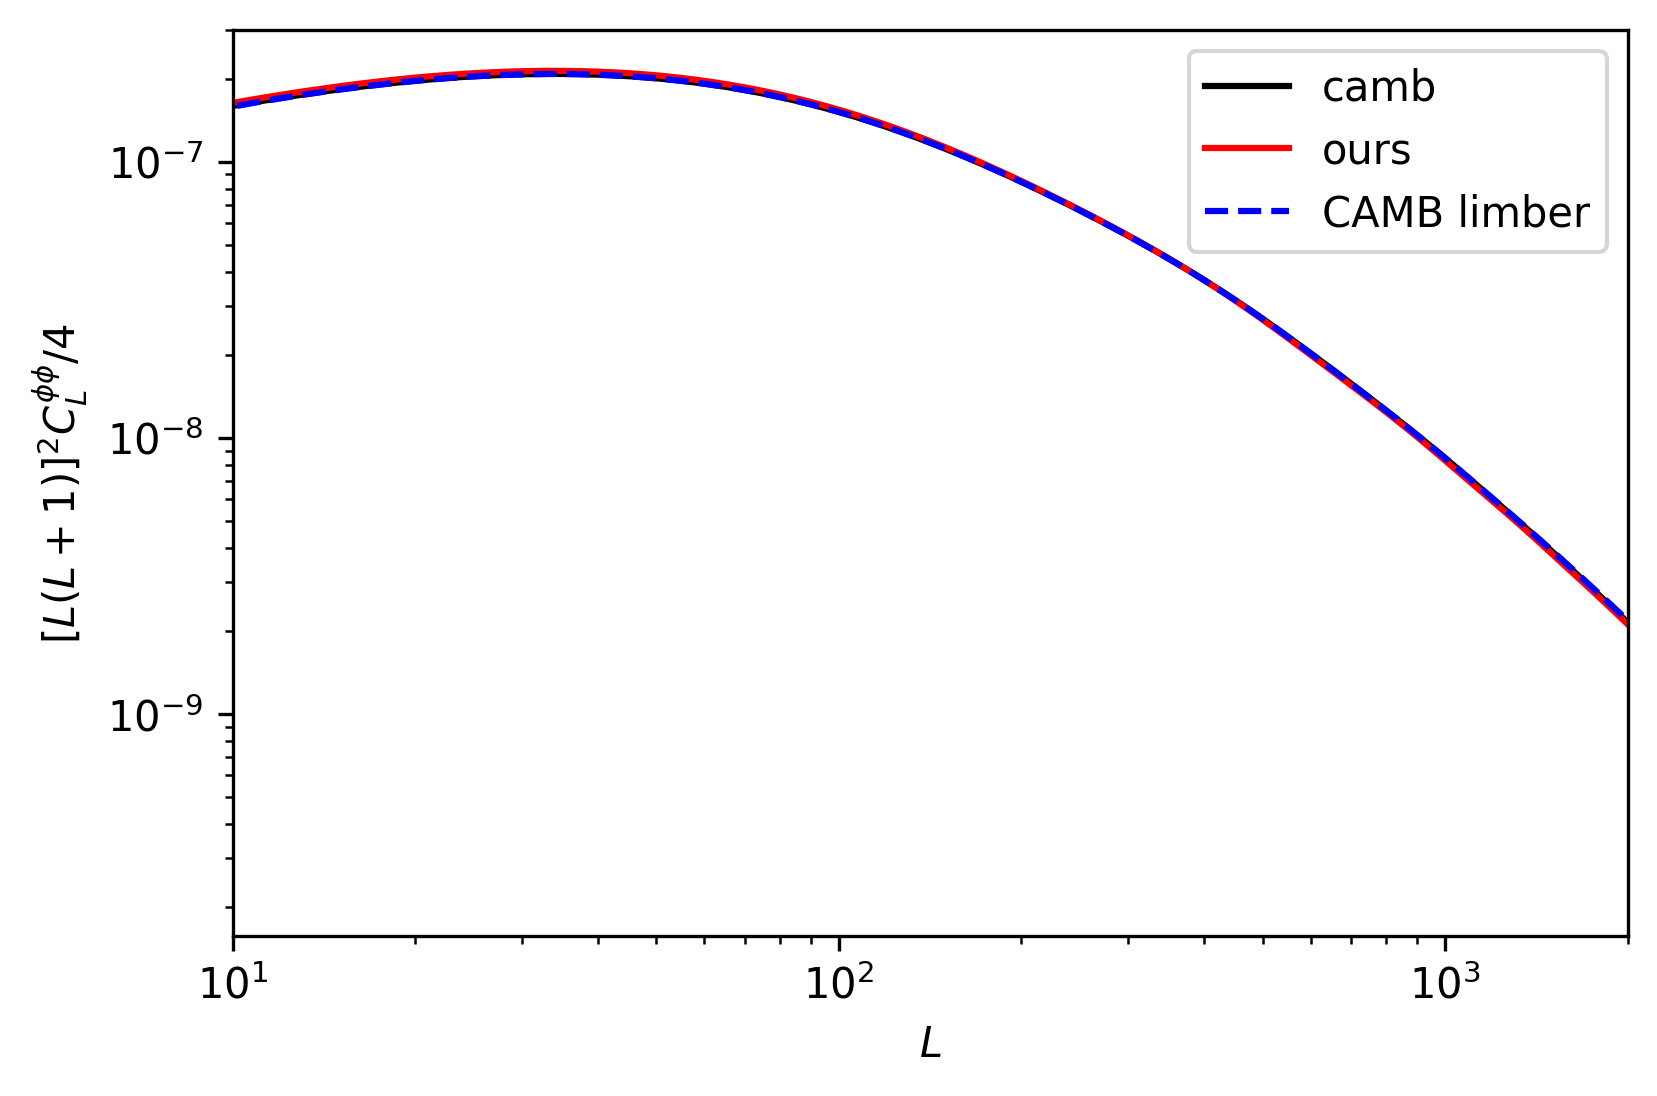

In [16]:
plt.figure(dpi = 300)
plt.plot(np.arange(int(max(ells)) + 1)[10:], cl[10:,0] * 2*np.pi / 4, 'k', label='camb')
plt.plot(ells, ClKK, 'r', label='ours')
plt.plot(ls, cl_kappa, 'b--', label='CAMB limber')


plt.ylabel('$[L(L+1)]^2C_L^{\phi\phi}/4$')
plt.xlabel('$L$')
plt.xlim([10,2000]);
plt.legend()
plt.loglog()

In [14]:
N0_ells = np.logspace(1, np.log10(5000), 500)
with open('LIMxCMBL/N0.npy', 'rb') as f:
    N0 = np.load(f)

[]

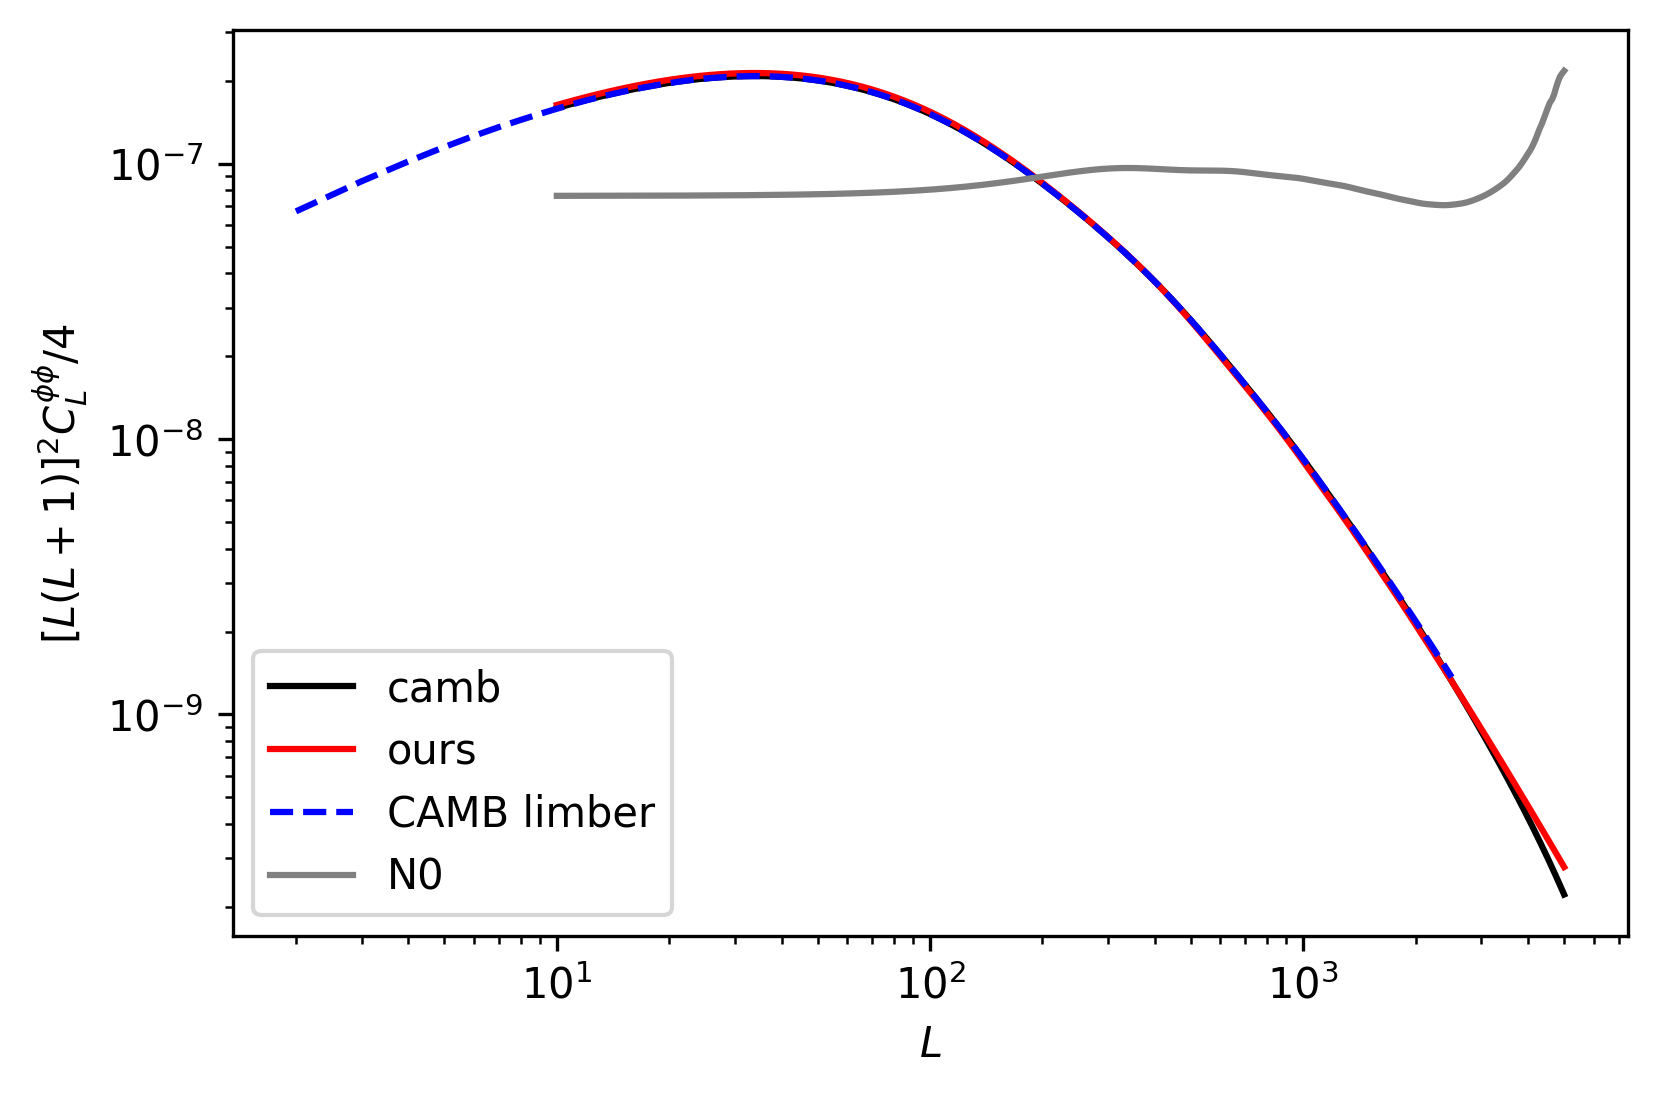

In [20]:
plt.figure(dpi = 300)
plt.plot(np.arange(int(max(ells)) + 1)[10:], cl[10:,0] * 2*np.pi / 4, 'k', label='camb')
plt.plot(ells, ClKK, 'r', label='ours')
plt.plot(ls, cl_kappa, 'b--', label='CAMB limber')

plt.plot(N0_ells, N0, label='N0', c='grey')

plt.ylabel('$[L(L+1)]^2C_L^{\phi\phi}/4$')
plt.xlabel('$L$')
# plt.xlim([10,2000]);
plt.legend()
plt.loglog()